# Simple pendulum using Lagrange's equation

Defines a LagrangianPendulum class that is used to generate basic pendulum plots from solving Lagrange's equations.

* Last revised 17-Mar-2019 by Dick Furnstahl (furnstahl.1@osu.edu).

## Euler-Lagrange equation

For a simple pendulum, the Lagrangian with generalized coordinate $\phi$ is

$\begin{align}
  \mathcal{L} = \frac12 m L^2 \dot\phi^2 - mgL(1 - \cos\phi)
\end{align}$

The Euler-Lagrange equation is

$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot\phi} = \frac{\partial\mathcal L}{\partial\phi}
 \quad\Longrightarrow\quad
 m L^2 \ddot \phi = -mgL\sin\phi
  \ \mbox{or}\ \ddot\phi = - \omega_0^2\sin\phi = 0
  \;.
\end{align}$

## Hamilton's equations

The generalized momentum corresponding to $\phi$ is

$\begin{align}
   \frac{\partial\mathcal{L}}{\partial \dot\phi} = m L^2 \dot\phi \equiv p_\phi
   \;.
\end{align}$

We can invert this equation to find $\dot\phi = p_\phi / m L^2$.
Constructing the Hamiltonian by Legendre transformation we find 

$\begin{align}
  \mathcal{H} &= \dot\phi p_\phi  - \mathcal{L} \\
              &= \frac{p_\phi^2}{m L^2} - \frac12 m L^2 \dot\phi^2 + mgL(1 - \cos\phi) \\
              &= \frac{p_\phi^2}{2 m L^2} + mgL(1 - \cos\phi)
              \;.
\end{align}$

Thus $\mathcal{H}$ is simply $T + V$.  Hamilton's equations are

$\begin{align}
  \dot\phi &= \frac{\partial\mathcal{H}}{\partial p_\phi} = \frac{p_\phi}{m L^2} \\
  \dot p_\phi &= -\frac{\partial\mathcal{H}}{\partial \phi} = -mgL \sin\phi 
  \;.
\end{align}$

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt

In [3]:
# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 12
plt.rcParams.update({'font.size': font_size})

## Pendulum class and utility functions

In [4]:
class DoublePendulum():
    """
    DOuble Pendulum class implements the parameters and Lagrange's equations for 
     a simple double pendulum (no driving or damping).
     
    Parameters
    ----------
    L1 : float
        length of pendulum 1
    L2 : float
        length of pendulum 2
    g : float
        gravitational acceleration at the earth's surface
    omega_0 : float
        natural frequency of the pendulum (\sqrt{g/l} where l is the 
        pendulum length) 
    mass1 : float
        mass of pendulum 1
    mass2 : float
        mass of pendulum 2

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    def __init__(self, L1=1., L2=1., mass1=1., mass2=1., g=1.
                ):
        self.L1 = L1
        self.L2 = L2
        self.g = g
        self.mass1 = mass1
        self.mass2 = mass2
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dphi/dt d^2phi/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with y[0] = theta1(t) and y[1] = d_theta1 = z1
                                      y[2] = theta2(t) and y[3] = d_theta2 = z2
            
        Returns
        -------
        
        """
        theta1, z1, theta2, z2 = y
        
        cos = np.cos(theta1 - theta2)
        sin = np.sin(theta1 - theta2)
        
        d_theta1 = z1
        d_z1 = (self.mass2 * self.g * np.sin(theta2) * cos \
                - self.mass2 * sin * (self.L1 * z1**2 * cos + self.L2 * z2**2) \
                - (self.mass1 + self.mass2) * self.g * np.sin(theta1) ) \
                / ( self.L1 * (self.mass1 + self.mass2 * sin**2) )

        
        d_theta2 = z2
        d_z2 = ( (self.mass1 + self.mass2) * (self.L1 * z1**2 * sin \
                - self.g * np.sin(theta2) + self.g * np.sin(theta1) * cos ) \
                + self.mass2 * self.L2 * z2**2 * sin * cos ) \
                / ( self.L2 * (self.mass1 + self.mass2 * sin**2) )
        
        return [ d_theta1, d_z1, d_theta2, d_z2 ]
    
    def solve_ode(self, t_pts, theta1_0, d_theta1_0, theta2_0, d_theta2_0, 
                  abserr=1.0e-9, relerr=1.0e-9):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [theta1_0, d_theta1_0, theta2_0, d_theta2_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        theta1_0, d_theta1_0, theta2_0, d_theta2_0 = solution.y

        return theta1_0, d_theta1_0, theta2_0, d_theta2_0
    
    def energy(y):
        
        theta1, theta1d, theta2, theta2d = y.T
        
        #potential energy
        U = -(mass1+mass2)*L1*g*np.cos(theta1) - mass2*L2*g*np.cos(theta2)
        
        #kinetic energy (split into 2 parts so i know what's what)
        m1 = 0.5*mass1*(L1*theta1d)**2
        m2 = 0.5*mass2((L1*theta1d)**2 + (L2*theta2d)**2 + 2*L1*L2*theta1d*theta2d*np.cos(theta1-theta2))
        T = m1 + m2
        return T + U
      

In [5]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [6]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## Part a) Make simple pendulum plots 

In [7]:
# Labels for individual plot axes
theta_vs_time_labels = (r'$t$', r'$\theta(t)$')
theta_dot_vs_time_labels = (r'$t$', r'$d\theta/dt(t)$')
state_space_labels = (r'$\theta$', r'$d\theta/dt$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

L1 = 1.
L2 = 1.
g = 1.
mass1 = 1.
mass2 = 1.

# Instantiate the double pendulum!!!! 
dp1 = DoublePendulum(L1=L1, L2=L2, g=g, mass1=mass1, mass2=mass2)


(<AxesSubplot:xlabel='$t$', ylabel='$\\theta(t)$'>,
 <matplotlib.lines.Line2D at 0x17aa54013a0>)

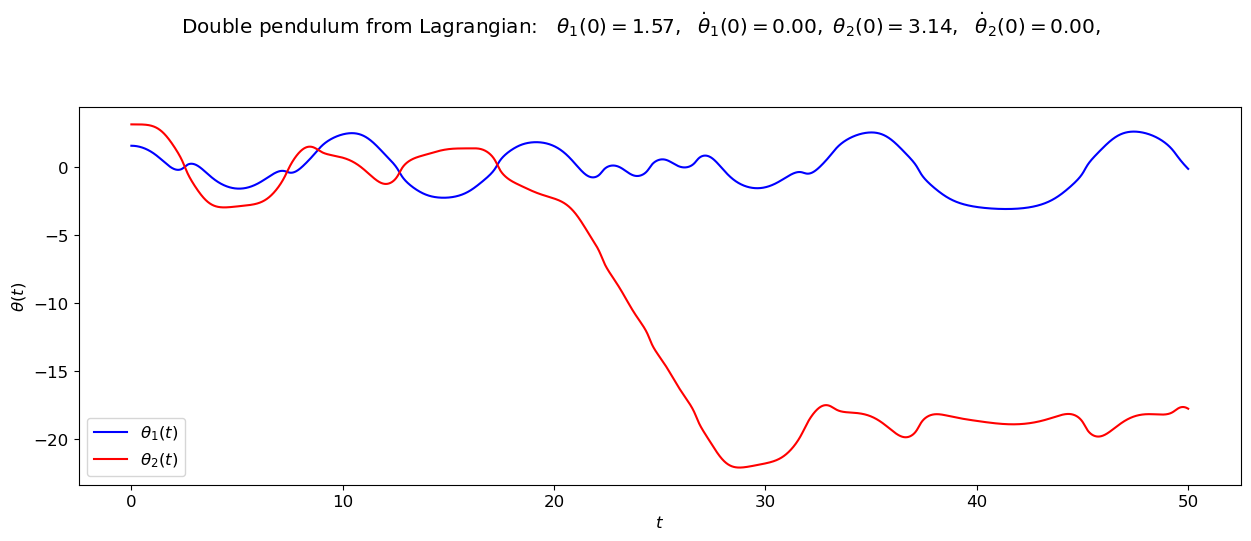

In [8]:
# both plots: same initial conditions
theta1_0 = np.pi/2
theta1_dot_0 = 0.
theta2_0 = np.pi
theta2_dot_0 = 0.

theta1, d_theta1, theta2, d_theta2 = dp1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0)


# start the plot!
fig = plt.figure(figsize=(15,5))
overall_title = 'Double pendulum from Lagrangian:  ' + \
                rf' $\theta_1(0) = {theta1_0:.2f},$' + \
                rf'  $\dot\theta_1(0)= {theta1_dot_0:.2f},$' + \
                rf' $\theta_2(0) = {theta2_0:.2f},$' + \
                rf'  $\dot\theta_2(0)= {theta2_dot_0:.2f},$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# first plot: phi plot 
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], theta1[start : stop], 
            axis_labels=theta_vs_time_labels, 
            color='blue',
            label=r'$\theta_1(t)$', 
            ax=ax_a)
plot_y_vs_x(t_pts[start : stop], theta2[start : stop], 
            axis_labels=theta_vs_time_labels, 
            color='red',
            label=r'$\theta_2(t)$', 
            ax=ax_a)    

And now I will do the produce the same plot but with different initial conditions. This will test to see if the pendulum still moves as expected. 

(<AxesSubplot:xlabel='$t$', ylabel='$\\theta(t)$'>,
 <matplotlib.lines.Line2D at 0x17aa6e3e340>)

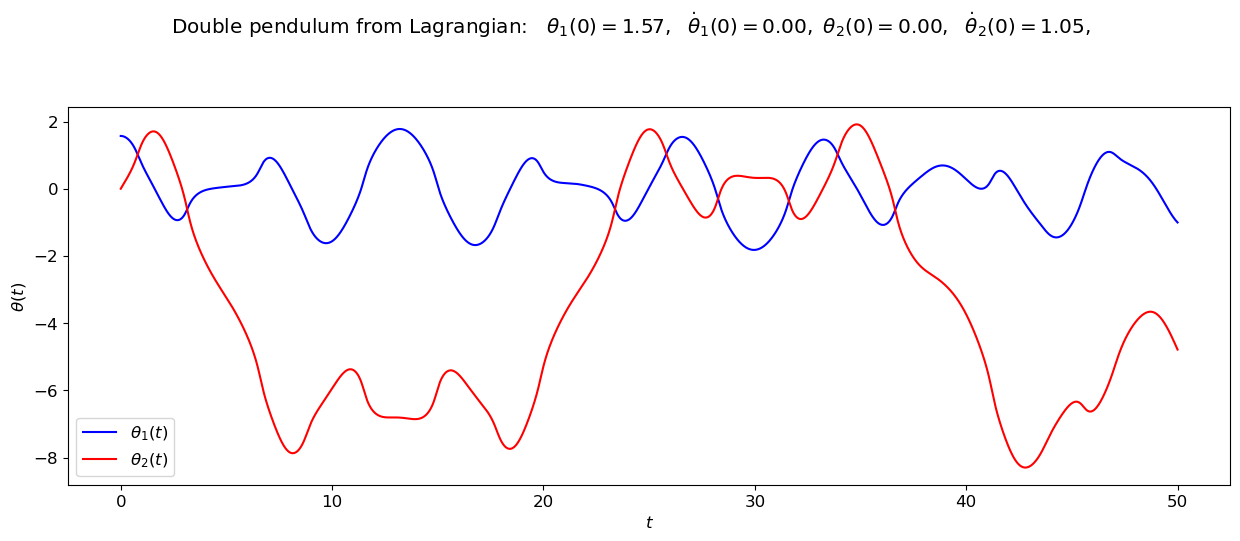

In [9]:
# both plots: same initial conditions
theta1_0 = np.pi/2
theta1_dot_0 = 0.
theta2_0 = 0.
theta2_dot_0 = np.pi/3

theta1, d_theta1, theta2, d_theta2 = dp1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0)


# start the plot!
fig = plt.figure(figsize=(15,5))
overall_title = 'Double pendulum from Lagrangian:  ' + \
                rf' $\theta_1(0) = {theta1_0:.2f},$' + \
                rf'  $\dot\theta_1(0)= {theta1_dot_0:.2f},$' + \
                rf' $\theta_2(0) = {theta2_0:.2f},$' + \
                rf'  $\dot\theta_2(0)= {theta2_dot_0:.2f},$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# first plot: phi plot 
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], theta1[start : stop], 
            axis_labels=theta_vs_time_labels, 
            color='blue',
            label=r'$\theta_1(t)$', 
            ax=ax_a)
plot_y_vs_x(t_pts[start : stop], theta2[start : stop], 
            axis_labels=theta_vs_time_labels, 
            color='red',
            label=r'$\theta_2(t)$', 
            ax=ax_a)    

## Part b) Testing for chaos

To do this, I will start with the same initial conditions but I will now make 2 pendulums. The difference is that $\theta_2$ is offset by an amount of 0.00001 

(1e-08, 2)

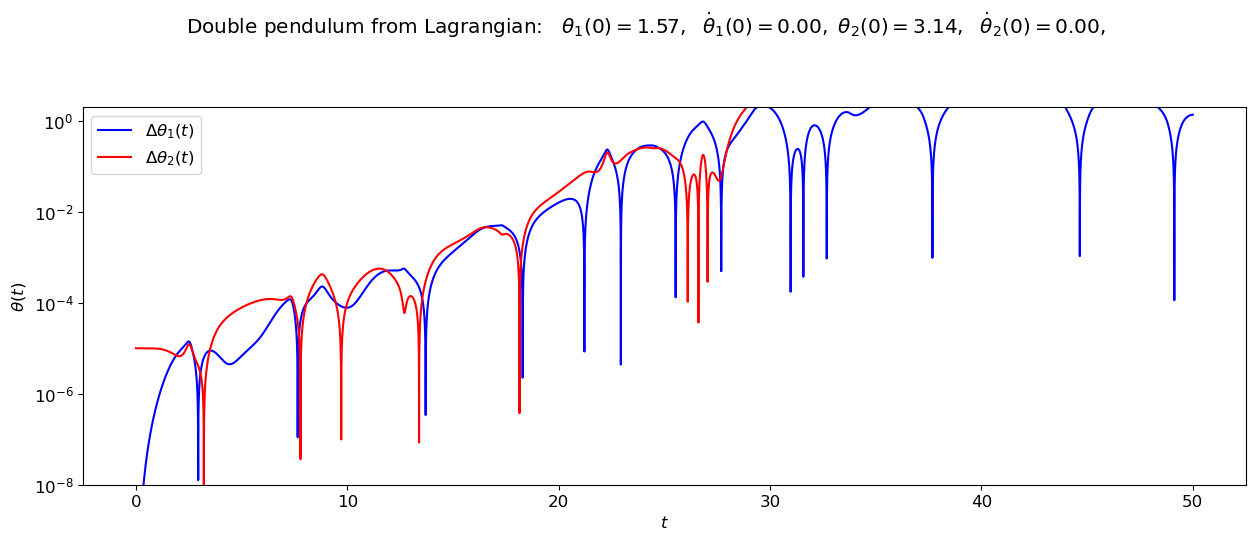

In [10]:
# both plots: same initial conditions
theta1_0 = np.pi/2
theta1_dot_0 = 0.
theta2_0 = np.pi
theta2_dot_0 = 0.

theta1, d_theta1, theta2, d_theta2 = dp1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0)
theta1b, d_theta1b, theta2b, d_theta2b = dp1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0-0.00001, theta2_dot_0)

# start the plot!
fig = plt.figure(figsize=(15,5))
overall_title = 'Double pendulum from Lagrangian:  ' + \
                rf' $\theta_1(0) = {theta1_0:.2f},$' + \
                rf'  $\dot\theta_1(0)= {theta1_dot_0:.2f},$' + \
                rf' $\theta_2(0) = {theta2_0:.2f},$' + \
                rf'  $\dot\theta_2(0)= {theta2_dot_0:.2f},$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
#creating our plot 
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], np.abs(theta1[start : stop] - theta1b[start : stop]), 
            axis_labels=theta_vs_time_labels, 
            color='blue',
            semilogy = True,
            label=r'$\Delta\theta_1(t)$', 
            ax=ax_a)
plot_y_vs_x(t_pts[start : stop], np.abs(theta2[start : stop] - theta2b[start : stop]), 
            axis_labels=theta_vs_time_labels, 
            color='red',
            semilogy = True,
            label=r'$\Delta\theta_2(t)$', 
            ax=ax_a)

ax_a.set_ylim(10**(-8), 2)

Again, we will test with different inital conditions. 

(1e-08, 2)

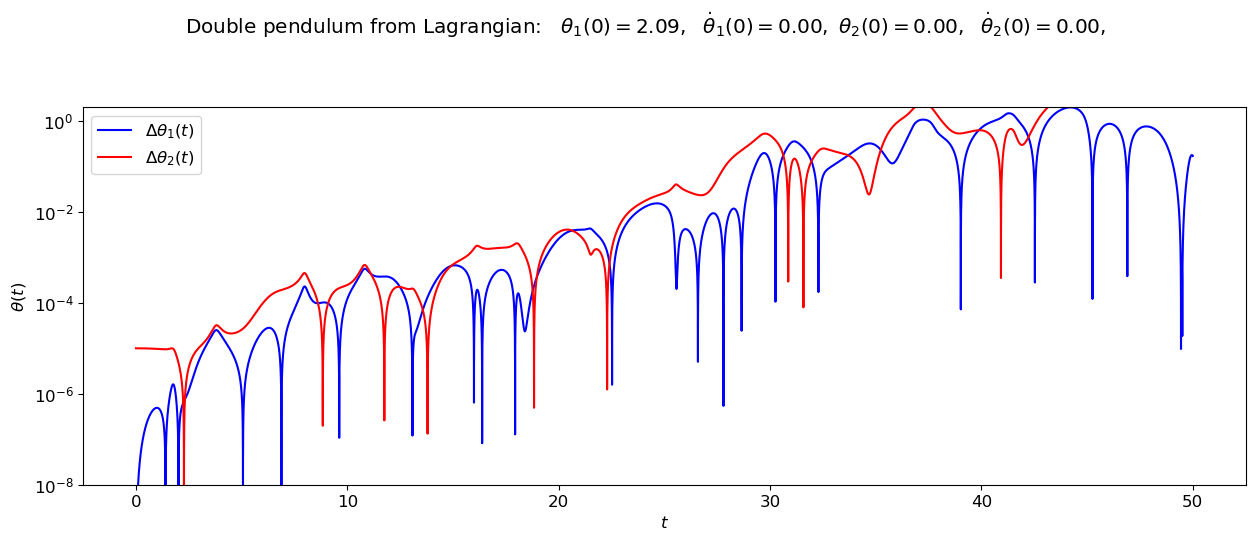

In [11]:
# both plots: same initial conditions
theta1_0 = 2* np.pi/3
theta1_dot_0 = 0.
theta2_0 = 0
theta2_dot_0 = 0.

theta1, d_theta1, theta2, d_theta2 = dp1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0)
theta1b, d_theta1b, theta2b, d_theta2b = dp1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0-0.00001, theta2_dot_0)

# start the plot!
fig = plt.figure(figsize=(15,5))
overall_title = 'Double pendulum from Lagrangian:  ' + \
                rf' $\theta_1(0) = {theta1_0:.2f},$' + \
                rf'  $\dot\theta_1(0)= {theta1_dot_0:.2f},$' + \
                rf' $\theta_2(0) = {theta2_0:.2f},$' + \
                rf'  $\dot\theta_2(0)= {theta2_dot_0:.2f},$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# first plot: phi plot 
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], np.abs(theta1[start : stop] - theta1b[start : stop]), 
            axis_labels=theta_vs_time_labels, 
            color='blue',
            semilogy = True,
            label=r'$\Delta\theta_1(t)$', 
            ax=ax_a)
plot_y_vs_x(t_pts[start : stop], np.abs(theta2[start : stop] - theta2b[start : stop]), 
            axis_labels=theta_vs_time_labels, 
            color='red',
            semilogy = True,
            label=r'$\Delta\theta_2(t)$', 
            ax=ax_a)

ax_a.set_ylim(10**(-8), 2)

## Part e) Animation Time

In [12]:
from matplotlib import animation, rc
from IPython.display import HTML

In [13]:
%%capture 
x_min = -5
x_max = 5
y_min = -5
y_max = 5

fig_anim = plt.figure(figsize=(6,2), num='Double Pendulum')
ax_anim = fig_anim.add_subplot(1,1,1)
ax_anim.set_xlim(x_min, x_max)
ax_anim.set_ylim(y_min, y_max)

# By assigning the first return from plot to line_anim, we can later change
#  the values in the line.
line_anim, = ax_anim.plot(x_pts, 
                          DoublePendulum(L1=L1, L2=L2, g=g, mass1=mass1, mass2=mass2), 
                          color='blue', lw=2)

fig_anim.tight_layout()

ValueError: x and y must have same first dimension, but have shapes (640,) and (1,)

In [14]:
def animate_pendulum(i):
    """This is the function called by FuncAnimation to create each frame,
        numbered by i.  So each i corresponds to a point in the t_pts
        array, with index i.
    """
    t = t_pts[i]
    y_pts = u_triangle(x_pts, t, c_wave, height, width) 

    line_anim.set_data(x_pts, y_pts)  # overwrite line_anim with new points
    return (line_anim,)   # this is needed for blit=True to work

In [15]:
frame_interval = 40.  # time between frames
frame_number = 100    # number of frames to include (index of t_pts)
anim = animation.FuncAnimation(fig_anim, 
                               animate_wave, 
                               init_func=None,
                               frames=frame_number, 
                               interval=frame_interval, 
                               blit=True,
                               repeat=False)

#fig.show()

NameError: name 'u_triangle' is not defined

In [ ]:
HTML(anim.to_jshtml())